In [ ]:
from glob import glob 

result_root_dir = "/workspace/data/results/variable_gender_comp"

In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, roc_curve, confusion_matrix, classification_report,
    precision_recall_curve, average_precision_score
)
from scipy.stats import mode

def pkl_load(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

# 모든 모델 결과 로드
pkl_files = glob(f"{result_root_dir}/*.pkl")
results_dict = {}

for pkl_file in pkl_files:
    model_name = pkl_file.split('/')[-1].split('.')[0]
    pkl_dict = pkl_load(pkl_file)
    results_dict[model_name] = pkl_dict
    print(f"✓ {model_name} 로드 완료")



## 성능 전체비교

In [ ]:
# 성능 전체비교 테이블 생성
from scipy.stats import t
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, matthews_corrcoef
)

def calculate_ci(values, confidence=0.95):
    """95% 신뢰구간 계산"""
    n = len(values)
    if n < 2:
        return np.nan, np.nan
    mean = np.mean(values)
    std = np.std(values, ddof=1)
    se = std / np.sqrt(n)
    t_value = t.ppf((1 + confidence) / 2, df=n-1)
    ci_lower = mean - t_value * se
    ci_upper = mean + t_value * se
    return ci_lower, ci_upper

def calculate_specificity(y_true, y_pred):
    """Specificity (True Negative Rate) 계산"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else 0.0

def calculate_balanced_accuracy(y_true, y_pred):
    """Balanced Accuracy 계산"""
    recall = recall_score(y_true, y_pred)
    specificity = calculate_specificity(y_true, y_pred)
    return (recall + specificity) / 2

def format_exp_name(exp_name):
    """실험 이름을 읽기 쉽게 포맷팅"""
    if not exp_name or not isinstance(exp_name, str):
        return exp_name
    
    parts = exp_name.replace('4_EXP_Methods_', '').split('_')
    if len(parts) >= 2:
        feature_set = parts[0]
        gender = parts[1]
        
        feature_map = {'A': '부모+청소년', 'P': '부모', 'Ad': '청소년'}
        gender_map = {'A': '전체', 'M': '남', 'FM': '여'}
        
        feature_label = feature_map.get(feature_set, feature_set)
        gender_label = gender_map.get(gender, gender)
        
        return f"{feature_label} ({gender_label})"
    return exp_name

# 모든 실험-모델 조합의 메트릭 수집
all_metrics = []

for exp_name, result in results_dict.items():
    # 실험 메타데이터 추출
    exp_name_clean = result.get('exp_name', exp_name)
    feature_set = result.get('feature_set', '')
    gender = result.get('gender', '')
    
    test_labels = result.get('test_labels')
    test_preds = result.get('test_preds', {})
    test_proba = result.get('test_proba', {})
    
    if test_labels is None:
        continue
    if not isinstance(test_preds, dict) or not isinstance(test_proba, dict):
        continue
    
    # 각 모델별로 처리
    for model_name in test_preds.keys():
        if model_name not in test_proba:
            continue
        
        preds_list = test_preds[model_name]
        proba_list = test_proba[model_name]
        
        if not isinstance(preds_list, list) or len(preds_list) == 0:
            continue
        if not isinstance(proba_list, list) or len(proba_list) == 0:
            continue
        
        # 각 fold별 메트릭 계산
        accs, precs, recalls, f1s, aucs, specs, bal_accs, mccs = [], [], [], [], [], [], [], []
        
        for fold_pred, fold_proba in zip(preds_list, proba_list):
            accs.append(accuracy_score(test_labels, fold_pred))
            precs.append(precision_score(test_labels, fold_pred, zero_division=0))
            recalls.append(recall_score(test_labels, fold_pred, zero_division=0))
            f1s.append(f1_score(test_labels, fold_pred, zero_division=0))
            aucs.append(roc_auc_score(test_labels, fold_proba))
            specs.append(calculate_specificity(test_labels, fold_pred))
            bal_accs.append(calculate_balanced_accuracy(test_labels, fold_pred))
            mccs.append(matthews_corrcoef(test_labels, fold_pred))
        
        # 평균 및 통계 계산
        def format_ci_mean_std(values, metric_name):
            mean_val = np.mean(values)
            std_val = np.std(values, ddof=1)
            ci_lower, ci_upper = calculate_ci(values)
            return {
                f"{metric_name}_mean": mean_val,
                f"{metric_name}_std": std_val,
                f"{metric_name}_ci_lower": ci_lower,
                f"{metric_name}_ci_upper": ci_upper,
            }
        
        metric_dict = {
            "Experiment": format_exp_name(exp_name_clean),
            "Exp_Name": exp_name_clean,
            "Feature_Set": feature_set,
            "Gender": gender,
            "Model": model_name,
            **format_ci_mean_std(accs, "Accuracy"),
            **format_ci_mean_std(precs, "Precision"),
            **format_ci_mean_std(recalls, "Recall"),
            **format_ci_mean_std(f1s, "F1"),
            **format_ci_mean_std(aucs, "ROC_AUC"),
            **format_ci_mean_std(specs, "Specificity"),
            **format_ci_mean_std(bal_accs, "Balanced_Accuracy"),
            **format_ci_mean_std(mccs, "MCC"),
        }
        
        all_metrics.append(metric_dict)

# DataFrame 생성
df_all_metrics = pd.DataFrame(all_metrics)

if len(df_all_metrics) > 0:
    # 실험 방법 순서 정의
    exp_order = [
        '4_EXP_Methods_A_A', '4_EXP_Methods_A_M', '4_EXP_Methods_A_FM',
        '4_EXP_Methods_P_A', '4_EXP_Methods_P_M', '4_EXP_Methods_P_FM',
        '4_EXP_Methods_Ad_A', '4_EXP_Methods_Ad_M', '4_EXP_Methods_Ad_FM'
    ]
    
    # 실험 순서에 맞게 정렬
    exp_order_dict = {exp: i for i, exp in enumerate(exp_order)}
    df_all_metrics['exp_order'] = df_all_metrics['Exp_Name'].map(lambda x: exp_order_dict.get(x, 999))
    df_all_metrics = df_all_metrics.sort_values(['exp_order', 'ROC_AUC_mean'], ascending=[True, False])
    df_all_metrics = df_all_metrics.drop('exp_order', axis=1)
    
    print("="*100)
    print("📊 전체 성능 비교 테이블 (모든 실험 방법 × 모든 모델)")
    print("="*100)
    
    # 주요 메트릭만 선택하여 표시
    display_cols = ['Experiment', 'Model', 'ROC_AUC_mean', 'ROC_AUC_std', 
                    'F1_mean', 'F1_std', 'Balanced_Accuracy_mean', 'Balanced_Accuracy_std',
                    'Precision_mean', 'Recall_mean', 'Accuracy_mean', 'MCC_mean']
    
    # 요약 테이블 생성 (CI 포함)
    summary_table = df_all_metrics[display_cols].copy()
    
    # CI 형식으로 표시할 컬럼 추가
    for metric in ['ROC_AUC', 'F1', 'Balanced_Accuracy']:
        summary_table[f"{metric}_CI"] = df_all_metrics.apply(
            lambda row: f"[{row[f'{metric}_ci_lower']:.3f}, {row[f'{metric}_ci_upper']:.3f}]",
            axis=1
        )
    
    # 컬럼명 정리
    summary_table_display = summary_table.copy()
    summary_table_display = summary_table_display.rename(columns={
        'ROC_AUC_mean': 'ROC AUC',
        'ROC_AUC_std': 'ROC AUC (std)',
        'ROC_AUC_CI': 'ROC AUC (95% CI)',
        'F1_mean': 'F1 Score',
        'F1_std': 'F1 (std)',
        'F1_CI': 'F1 (95% CI)',
        'Balanced_Accuracy_mean': 'Balanced Acc',
        'Balanced_Accuracy_std': 'Bal Acc (std)',
        'Balanced_Accuracy_CI': 'Bal Acc (95% CI)',
        'Precision_mean': 'Precision',
        'Recall_mean': 'Recall',
        'Accuracy_mean': 'Accuracy',
        'MCC_mean': 'MCC'
    })
    
    # 소수점 자리수 조정
    for col in summary_table_display.columns:
        if col not in ['Experiment', 'Model'] and '_CI' not in col:
            if summary_table_display[col].dtype in [np.float64, np.float32]:
                summary_table_display[col] = summary_table_display[col].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")
    
    display(summary_table_display)
    
    # 실험 방법별 최고 성능 모델 표시
    print("\n" + "="*100)
    print("🏆 실험 방법별 최고 성능 모델 (ROC AUC 기준)")
    print("="*100)
    
    best_models = []
    for exp_name in exp_order:
        exp_data = df_all_metrics[df_all_metrics['Exp_Name'] == exp_name]
        if len(exp_data) > 0:
            best_idx = exp_data['ROC_AUC_mean'].idxmax()
            best_row = exp_data.loc[best_idx]
            best_models.append({
                'Experiment': best_row['Experiment'],
                'Model': best_row['Model'],
                'ROC_AUC': best_row['ROC_AUC_mean'],
                'ROC_AUC_CI': f"[{best_row['ROC_AUC_ci_lower']:.3f}, {best_row['ROC_AUC_ci_upper']:.3f}]",
                'F1': best_row['F1_mean'],
                'Balanced_Accuracy': best_row['Balanced_Accuracy_mean']
            })
    
    if len(best_models) > 0:
        best_df = pd.DataFrame(best_models)
        display(best_df)
    
    # 실험 방법별 평균 성능 (모든 모델 평균)
    print("\n" + "="*100)
    print("📊 실험 방법별 평균 성능 (모든 모델 평균)")
    print("="*100)
    
    exp_avg = df_all_metrics.groupby('Experiment').agg({
        'ROC_AUC_mean': 'mean',
        'F1_mean': 'mean',
        'Balanced_Accuracy_mean': 'mean',
        'Precision_mean': 'mean',
        'Recall_mean': 'mean',
        'Accuracy_mean': 'mean',
        'MCC_mean': 'mean'
    }).round(4)
    exp_avg = exp_avg.sort_values('ROC_AUC_mean', ascending=False)
    exp_avg.columns = ['ROC AUC', 'F1 Score', 'Balanced Acc', 'Precision', 'Recall', 'Accuracy', 'MCC']
    print(exp_avg.round(3).to_markdown())
    
    print(f"\n✅ 총 {len(df_all_metrics)}개 조합 (실험 방법 {len(df_all_metrics['Exp_Name'].unique())}개 × 모델 {len(df_all_metrics['Model'].unique())}개) 분석 완료")
else:
    print("⚠️  비교할 데이터가 없습니다.")

# 1. ROC / PR Curve 

## 3. Confusion Matrix 비교


In [ ]:
import os 
# Visualize Confusion Matrix by experimental method for the LightGBM model
target_model = 'LightGBM'

def format_exp_name(exp_name):
    """Format experimental name to be human-readable in English"""
    if not exp_name or not isinstance(exp_name, str):
        return exp_name

    parts = exp_name.replace('4_EXP_Methods_', '').split('_')
    if len(parts) >= 2:
        feature_set = parts[0]
        gender = parts[1]

        feature_map = {'A': 'Parents+Adolescent', 'P': 'Parents', 'Ad': 'Adolescent'}
        gender_map = {'A': 'All', 'M': 'Male', 'FM': 'Female'}

        feature_label = feature_map.get(feature_set, feature_set)
        gender_label = gender_map.get(gender, gender)

        return f"{feature_label} ({gender_label})"
    return exp_name

# Collect all experimental combinations for LightGBM model
lightgbm_combinations = []
for exp_name, result in results_dict.items():
    exp_name_clean = result.get('exp_name', exp_name)
    test_labels = result.get('test_labels')
    test_preds = result.get('test_preds', {})

    if test_labels is None:
        continue
    if not isinstance(test_preds, dict):
        continue

    if target_model not in test_preds:
        continue

    preds_list = test_preds[target_model]
    if isinstance(preds_list, list) and len(preds_list) > 0:
        lightgbm_combinations.append((exp_name_clean, test_labels, preds_list))

if len(lightgbm_combinations) == 0:
    print(f"⚠️  No data available for {target_model} model.")
else:
    # Calculate AUC for each experimental method
    exp_combinations_with_auc = []

    for exp_name, test_labels, preds_list in lightgbm_combinations:
        # AUC requires test_proba
        for exp_key, result in results_dict.items():
            exp_name_clean = result.get('exp_name', exp_key)
            if exp_name_clean == exp_name:
                test_proba = result.get('test_proba', {})
                if target_model in test_proba:
                    proba_list = test_proba[target_model]
                    if isinstance(proba_list, list) and len(proba_list) > 0:
                        proba_array = np.array(proba_list)
                        avg_proba = np.mean(proba_array, axis=0)
                        auc = roc_auc_score(test_labels, avg_proba)
                        exp_combinations_with_auc.append((exp_name, auc, test_labels, preds_list))
                        break

    # Sort by AUC in descending order
    exp_combinations_with_auc.sort(key=lambda x: x[1], reverse=True)

    # Arrange in 3x3 layout based on feature set and gender order
    # Order: A_A, A_M, A_FM, P_A, P_M, P_FM, Ad_A, Ad_M, Ad_FM
    exp_order = [
        '4_EXP_Methods_A_A', '4_EXP_Methods_A_M', '4_EXP_Methods_A_FM',
        '4_EXP_Methods_P_A', '4_EXP_Methods_P_M', '4_EXP_Methods_P_FM',
        '4_EXP_Methods_Ad_A', '4_EXP_Methods_Ad_M', '4_EXP_Methods_Ad_FM'
    ]

    # Rearrange based on order
    layout_combinations = []
    layout_auc_values = []

    for exp_name in exp_order:
        for exp_key, auc, test_labels, preds_list in exp_combinations_with_auc:
            if exp_key == exp_name:
                layout_combinations.append((exp_key, test_labels, preds_list))
                layout_auc_values.append(auc)
                break

    # If any experimental results are not in the specified order, add them to the end
    for exp_key, auc, test_labels, preds_list in exp_combinations_with_auc:
        if exp_key not in [x[0] for x in layout_combinations]:
            layout_combinations.append((exp_key, test_labels, preds_list))
            layout_auc_values.append(auc)

    cols = 3
    rows = 3

    # Create 3x3 layout
    fig, axes = plt.subplots(rows, cols, figsize=(18, 18))
    axes = axes.flatten()

    # Find max value from all confusion matrices for shared colorbar
    all_cm_values = []
    for exp_name, test_labels, preds_list in layout_combinations:
        preds_array = np.array(preds_list)
        hard_voting_pred = mode(preds_array, axis=0, keepdims=False).mode
        cm = confusion_matrix(test_labels, hard_voting_pred)
        all_cm_values.append(cm)

    vmin = 0
    vmax = max([cm.max() for cm in all_cm_values])

    # Plot confusion matrix for each experimental method (with colorbar turned off)
    for idx, (exp_name, test_labels, preds_list) in enumerate(layout_combinations):
        formatted_label = format_exp_name(exp_name)

        # Hard Voting (majority vote)
        preds_array = np.array(preds_list)  # (n_folds, n_samples)
        hard_voting_pred = mode(preds_array, axis=0, keepdims=False).mode

        # Calculate confusion matrix (count)
        cm = confusion_matrix(test_labels, hard_voting_pred)

        # Metrics calculation
        accuracy = accuracy_score(test_labels, hard_voting_pred)
        precision = precision_score(test_labels, hard_voting_pred, zero_division=0)
        recall = recall_score(test_labels, hard_voting_pred, zero_division=0)
        f1 = f1_score(test_labels, hard_voting_pred, zero_division=0)

        # Visualization
        ax = axes[idx]

        # Confusion matrix heatmap (count, without colorbar)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                    cbar=False, linewidths=2, linecolor='black', vmin=vmin, vmax=vmax,
                    annot_kws={'size': 11, 'weight': 'bold'})

        # Set title (include AUC)
        auc_val = layout_auc_values[idx] if idx < len(layout_auc_values) else 0.0
        ax.set_title(f'{formatted_label}\nAcc: {accuracy:.3f} | F1: {f1:.3f} | AUC: {auc_val:.3f}',
                     fontsize=10, fontweight='bold', pad=8)
        ax.set_xlabel('Predicted', fontsize=9, fontweight='bold')
        ax.set_ylabel('Actual', fontsize=9, fontweight='bold')
        ax.set_xticklabels(['Class 0', 'Class 1'], fontsize=9)
        ax.set_yticklabels(['Class 0', 'Class 1'], fontsize=9, rotation=0)

    # Remove unused subplots
    for idx in range(len(layout_combinations), len(axes)):
        fig.delaxes(axes[idx])

    # Add shared colorbar on the right (covering all 3 rows)
    # Reserve space for colorbar before calling tight_layout
    plt.tight_layout(rect=[0, 0, 0.92, 1.0])  # [left, bottom, right, top]

    # Create axes for colorbar (match the entire height of the 3 rows)
    cbar_ax = fig.add_axes([0.93, 0.1, 0.015, 0.8])  # [left, bottom, width, height]

    # Create shared colorbar (using dummy data)
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Count', fontsize=11, fontweight='bold')
    cbar.ax.tick_params(labelsize=9)

    plt.suptitle(f'{target_model} - Confusion Matrix by Experimental Methods (Count)',
                 fontsize=16, fontweight='bold', y=1.02)
    plt.show()

    # Print metrics table
    print("=" * 80)
    print(f"{target_model} model - Confusion Matrix Analysis by Experimental Method")
    print("=" * 80)
    print(f"{'Rank':<5} {'Experiment Method':<40} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1':<10} {'AUC':<10}")
    
    print("-" * 80)

    for rank, (exp_name, test_labels, preds_list) in enumerate(layout_combinations, 1):
        formatted_label = format_exp_name(exp_name)

        # Hard Voting
        preds_array = np.array(preds_list)
        hard_voting_pred = mode(preds_array, axis=0, keepdims=False).mode

        # Metric calculation
        accuracy = accuracy_score(test_labels, hard_voting_pred)
        precision = precision_score(test_labels, hard_voting_pred, zero_division=0)
        recall = recall_score(test_labels, hard_voting_pred, zero_division=0)
        f1 = f1_score(test_labels, hard_voting_pred, zero_division=0)
        auc_val = layout_auc_values[rank - 1] if rank <= len(layout_auc_values) else 0.0

        print(f"{rank:<5} {formatted_label:<40} {accuracy:<10.4f} {precision:<10.4f} {recall:<10.4f} {f1:<10.4f} {auc_val:<10.4f}")

    print(f"\n✅ Displayed Confusion Matrices for {len(layout_combinations)} experimental methods successfully.")


## Feature 분석

In [ ]:
from glob import glob 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import json
import pickle

# PKL 파일 로드
pkl_files = glob("/workspace/data/results/variable_gender_comp/*.pkl")
pkl_files = [f for f in pkl_files if not f.endswith('_top7.pkl')]  # top7.pkl 제외

def pkl_load(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

# 실험 이름 포맷팅 함수
def format_exp_name(exp_name):
    """실험 이름을 읽기 쉽게 포맷팅"""
    if not exp_name or not isinstance(exp_name, str):
        return exp_name
    
    parts = exp_name.replace('4_EXP_Methods_', '').replace('.pkl', '').split('_')
    if len(parts) >= 2:
        feature_set = parts[0]
        gender = parts[1]
        
        feature_map = {'A': '부모+청소년', 'P': '부모', 'Ad': '청소년'}
        gender_map = {'A': '전체', 'M': '남', 'FM': '여'}
        
        feature_label = feature_map.get(feature_set, feature_set)
        gender_label = gender_map.get(gender, gender)
        
        return f"{feature_label} ({gender_label})"
    return exp_name

# 변수 카테고리 정보 로드
with open('/workspace/data/variable_category.json', 'r', encoding='utf-8') as f:
    var_categories = json.load(f)

parent_vars = [v['name'] for v in var_categories['parent_variables']]
adolescent_vars = [v['name'] for v in var_categories['adolescent_variables']]

# 모든 PKL 파일에서 feature importance 추출 및 데이터 통합
all_features_data = []
feature_frequency = Counter()

for pkl_file in sorted(pkl_files):
    pkl_data = pkl_load(pkl_file)
    exp_name = pkl_file.split('/')[-1].replace('.pkl', '')
    exp_name_formatted = format_exp_name(exp_name)
    
    # Feature importance 추출 (LightGBM 모델 사용)
    if 'feature_importances' in pkl_data and 'LightGBM' in pkl_data['feature_importances']:
        feature_importance_df = pkl_data['feature_importances']['LightGBM']
        
        # 부모/청소년 변인만 필터링
        filtered_features = feature_importance_df[
            feature_importance_df['feature'].isin(parent_vars + adolescent_vars)
        ]
        
        for _, row in filtered_features.iterrows():
            feature = row['feature']
            importance = row['importance']
            
            all_features_data.append({
                'Experiment': exp_name_formatted,
                'Exp_Name': exp_name,
                'Feature': feature,
                'Importance': importance
            })
            
            feature_frequency[feature] += 1

df_features = pd.DataFrame(all_features_data)

print(f"✅ 총 {len(pkl_files)}개 실험 방법의 Feature Importance 로드 완료")
print(f"📊 총 {len(df_features)}개 feature-실험 조합")
print(f"🔍 고유 feature 수: {len(df_features['Feature'].unique())}")
print(f"📋 부모 변수: {len([f for f in df_features['Feature'].unique() if f in parent_vars])}개")
print(f"📋 청소년 변수: {len([f for f in df_features['Feature'].unique() if f in adolescent_vars])}개")



In [ ]:
import matplotlib.font_manager as fm

# 2. Feature Importance Heatmap (실험별 × Feature별) - 개선 버전
# 나눔고딕 폰트 경로 지정 및 설정
nanumgothic_font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
if os.path.exists(nanumgothic_font_path):
    fm.fontManager.addfont(nanumgothic_font_path)
    plt.rc('font', family='NanumGothic')
else:
    print("경고: NanumGothic 폰트가 존재하지 않습니다. 한글이 깨질 수 있습니다.")

# 피벗 테이블 생성
pivot_df = df_features.pivot_table(
    index='Feature', 
    columns='Experiment', 
    values='Importance', 
    aggfunc='mean'
).fillna(0)

# Feature 카테고리 정보를 별도 Series로 저장
feature_category = pd.Series(
    {feat: '부모' if feat in parent_vars else ('청소년' if feat in adolescent_vars else '기타') 
     for feat in pivot_df.index},
    name='Category'
)

# 실험 순서 정의 (변인별, 성별별)
exp_order = [
    '부모+청소년 (전체)', '부모+청소년 (남)', '부모+청소년 (여)',
    '부모 (전체)', '부모 (남)', '부모 (여)',
    '청소년 (전체)', '청소년 (남)', '청소년 (여)'
]

# 존재하는 실험만 필터링
available_exps = [exp for exp in exp_order if exp in pivot_df.columns]
pivot_df = pivot_df[available_exps]

# Feature를 카테고리별로 정렬 (부모 → 청소년 → 기타)
category_order = ['부모', '청소년', '기타']
category_order_map = {cat: i for i, cat in enumerate(category_order)}

# 부모/청소년 변인에 해당하는 모든 feature 사용 (상위 제한 없음)
# 부모/청소년 변인만 필터링 (이미 셀 8에서 필터링했지만, 혹시 모를 경우를 대비)
all_features = [f for f in pivot_df.index 
                if feature_category[f] in ['부모', '청소년']]

# 카테고리별로 정렬된 feature 리스트 생성
feature_order = []
for category in ['부모', '청소년']:  # 기타 제외
    cat_features = [f for f in all_features if feature_category[f] == category]
    # 각 카테고리 내에서도 importance 순으로 정렬
    cat_features_sorted = sorted(cat_features, 
                                 key=lambda x: pivot_df.loc[x].mean(), 
                                 reverse=True)
    feature_order.extend(cat_features_sorted)

pivot_df_plot = pivot_df.loc[feature_order, available_exps]

# 실험 그룹 정보 추출 (변인별, 성별별)
def get_feature_set(exp_name):
    if '부모+청소년' in exp_name:
        return '부모+청소년'
    elif '부모' in exp_name:
        return '부모'
    elif '청소년' in exp_name:
        return '청소년'
    return '기타'

def get_gender(exp_name):
    if '(전체)' in exp_name:
        return '전체'
    elif '(남)' in exp_name:
        return '남'
    elif '(여)' in exp_name:
        return '여'
    return '기타'

# 히트맵 생성 (feature 개수에 따라 크기 조정)
n_features = len(feature_order)
n_experiments = len(available_exps)
fig_height = max(12, n_features * 0.6)  # feature당 0.6인치
fig_width = max(16, n_experiments * 1.2)  # 실험당 1.2인치
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# 히트맵 그리기
sns.heatmap(
    pivot_df_plot, 
    annot=True, 
    fmt='.1f', 
    cmap='YlOrRd', 
    cbar_kws={'label': 'Feature Importance', 'shrink': 0.8},
    linewidths=0.5,
    linecolor='gray',
    annot_kws={'size': 7, 'fontfamily': 'NanumSquare'},
    ax=ax
)

# 행(Feature) 카테고리별 구분선 추가
current_category = None
for i, feature in enumerate(feature_order):
    category = feature_category[feature]
    if current_category != category:
        if current_category is not None:
            ax.axhline(i, color='black', linewidth=2, linestyle='-')
        current_category = category

# 열(실험) 변인별 구분선 추가
current_feature_set = None
for j, exp in enumerate(available_exps):
    feature_set = get_feature_set(exp)
    if current_feature_set != feature_set:
        if current_feature_set is not None:
            ax.axvline(j, color='black', linewidth=2, linestyle='-')
        current_feature_set = feature_set

# 행 레이블 설정 및 카테고리별 색상 적용
y_labels = []
y_colors = []
for feature in feature_order:
    category = feature_category[feature]
    color = '#3498db' if category == '부모' else ('#e74c3c' if category == '청소년' else '#95a5a6')
    y_labels.append(feature)
    y_colors.append(color)

ax.set_yticks(range(len(feature_order)))
ax.set_yticklabels(y_labels, fontsize=9, fontfamily='NanumSquare', rotation=0)

# 각 행 레이블에 색상 적용
for i, (label, color) in enumerate(zip(ax.get_yticklabels(), y_colors)):
    label.set_color(color)
    label.set_fontweight('bold')

# 열 레이블 개선 (변인과 성별 구분)
x_labels = []
x_colors = []
gender_colors = {'전체': '#2c3e50', '남': '#3498db', '여': '#e74c3c'}
for exp in available_exps:
    feature_set = get_feature_set(exp)
    gender = get_gender(exp)
    x_labels.append(f"{feature_set}\n({gender})")
    x_colors.append(gender_colors.get(gender, '#95a5a6'))

ax.set_xticks(range(len(available_exps)))
ax.set_xticklabels(x_labels, fontsize=9, fontfamily='NanumSquare', rotation=0, ha='center')

# 각 열 레이블에 성별별 색상 적용
for i, (label, color) in enumerate(zip(ax.get_xticklabels(), x_colors)):
    label.set_color(color)
    label.set_fontweight('bold')

# 제목 및 레이블
plt.title('Feature Importance Heatmap (실험별 × Feature별)\n[변인별/성별 구분]', 
          fontsize=15, fontweight='bold', pad=25, fontfamily='NanumSquare')
plt.xlabel('실험 방법 (변인별/성별)', fontsize=12, fontweight='bold', fontfamily='NanumSquare')
plt.ylabel('Feature (카테고리별)', fontsize=12, fontweight='bold', fontfamily='NanumSquare')

# 범례 추가 (카테고리별 및 성별별 색상)
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [
    Patch(facecolor='#3498db', label='부모 변수', alpha=0.7),
    Patch(facecolor='#e74c3c', label='청소년 변수', alpha=0.7),
    Patch(facecolor='#95a5a6', label='기타 변수', alpha=0.7),
    Line2D([0], [0], color='none', label=''),  # 구분선
    Line2D([0], [0], color='#2c3e50', linewidth=2, label='전체 성별'),
    Line2D([0], [0], color='#3498db', linewidth=2, label='남성'),
    Line2D([0], [0], color='#e74c3c', linewidth=2, label='여성')
]
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1), 
          fontsize=9, prop={'family': 'NanumSquare'}, framealpha=0.9, title='범례')

# 그룹 헤더 추가 (변인별)
from matplotlib.patches import Rectangle
y_pos = -0.5
for i, feature_set in enumerate(['부모+청소년', '부모', '청소년']):
    matching_exps = [j for j, exp in enumerate(available_exps) if get_feature_set(exp) == feature_set]
    if matching_exps:
        start_col = min(matching_exps)
        end_col = max(matching_exps)
        width = end_col - start_col + 1
        rect = Rectangle((start_col - 0.5, y_pos), width, 0.3, 
                        facecolor='lightgray', edgecolor='black', linewidth=1.5, alpha=0.3)
        ax.add_patch(rect)
        ax.text(start_col + width/2 - 0.5, y_pos + 0.15, feature_set, 
               ha='center', va='center', fontsize=10, fontweight='bold', 
               fontfamily='NanumSquare')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print(f"📊 Feature Importance Heatmap 데이터 (부모/청소년 변인 전체: {len(feature_order)}개 features)")
print("="*80)
print(f"  - 부모 변수: {len([f for f in feature_order if feature_category[f] == '부모'])}개")
print(f"  - 청소년 변수: {len([f for f in feature_order if feature_category[f] == '청소년'])}개")
print("\n[변인별 그룹]")
print("- 부모+청소년: 부모와 청소년 변수 모두 포함")
print("- 부모: 부모 변수만 포함")
print("- 청소년: 청소년 변수만 포함")
print("\n[성별 그룹]")
print("- 전체: 전체 성별")
print("- 남: 남성만")
print("- 여: 여성만")
print("\n[Feature 카테고리]")
print("- 부모 변수: 파란색")
print("- 청소년 변수: 빨간색")
display(pivot_df_plot.round(1))


In [ ]:
# 5. 종합 요약: 가장 중요한 Features (모든 실험 평균)
overall_importance = df_features.groupby('Feature').agg({
    'Importance': ['mean', 'std', 'count'],
    'Category': 'first'
}).reset_index()
overall_importance.columns = ['Feature', 'Mean_Importance', 'Std_Importance', 'Frequency', 'Category']
overall_importance = overall_importance.sort_values('Mean_Importance', ascending=False)

# 상위 15개 feature 시각화
top15_overall = overall_importance.head(15)

fig, ax = plt.subplots(figsize=(12, 8))
colors_map = {'부모': '#3498db', '청소년': '#e74c3c', '기타': '#95a5a6'}
bar_colors = [colors_map.get(cat, '#95a5a6') for cat in top15_overall['Category']]

bars = ax.barh(range(len(top15_overall)), top15_overall['Mean_Importance'], 
               xerr=top15_overall['Std_Importance'], color=bar_colors, alpha=0.8, capsize=3)
ax.set_yticks(range(len(top15_overall)))
ax.set_yticklabels(top15_overall['Feature'], fontsize=10)
ax.set_xlabel('평균 Importance (표준편차)', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Features - 전체 실험 평균 Importance', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3, linestyle='--')

# 범례
legend_elements = [Patch(facecolor=colors_map[cat], label=cat) for cat in colors_map.keys()]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

# 값 표시
for i, (_, row) in enumerate(top15_overall.iterrows()):
    ax.text(row['Mean_Importance'] + row['Std_Importance'] + 20, i, 
            f"{row['Mean_Importance']:.1f}±{row['Std_Importance']:.1f}\n(n={int(row['Frequency'])})", 
            va='center', fontsize=8)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("📊 전체 실험 종합 - Top 15 Features")
print("="*80)
display(top15_overall[['Feature', 'Category', 'Mean_Importance', 'Std_Importance', 'Frequency']].round(2))

print("\n✅ Feature 분석 요약 완료!")


🔎 SHAP Dot Plot Summary (4_EXP_Methods_P_M: LightGBM)


/opt/conda/lib/python3.11/site-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  plt.tight_layout()
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


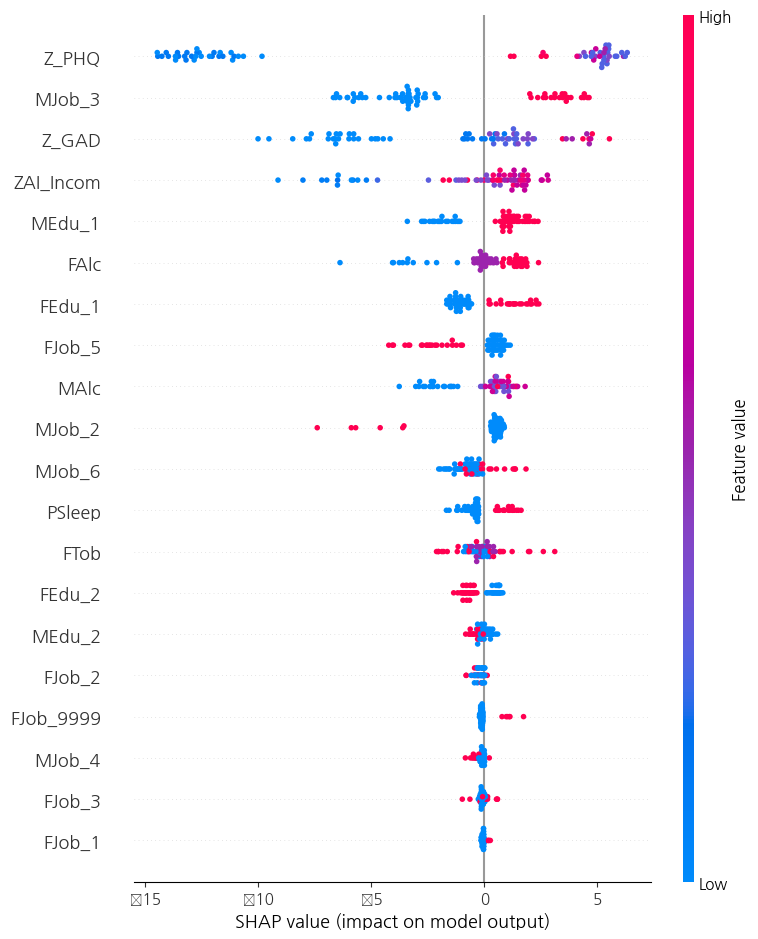

In [10]:
# SHAP value 시각화 (dot plot 형태로!)

import shap

# SHAP 값을 담은 results_dict dict에서 하나의 실험을 예시로 뽑아서 plot합니다.
# 여러 모델도 저장되어 있으므로, LightGBM/RandomForest 등 지원되는 모델 위주로 plot

# 1. 예시 실험 및 모델 선택 (여기서는 첫번째 실험/모델을 선택)
example_exp_name = next(iter(results_dict.keys()))
example_result = results_dict[example_exp_name]

# SHAP value와 feature 정보 가져오기
# test set의 shap_values만 저장되어 있음
shap_values_dict = example_result.get("shap_values_test", {})

# 사용할 모델명 정하기 (예: LightGBM, RandomForest 등)
example_model_name = None
for model in ['LightGBM', 'RandomForest', 'GradientBoosting', 'CatBoost', 'XGBoost']:
    if model in shap_values_dict:
        example_model_name = model
        break

if shap_values_dict and example_model_name:
    print("="*100)
    print(f"🔎 SHAP Dot Plot Summary ({example_exp_name}: {example_model_name})")
    print("="*100)
    shap_list = shap_values_dict[example_model_name]
    # Fold 0 기준으로 예시를 그림
    if isinstance(shap_list, list) and len(shap_list) > 0:
        shap_values = shap_list[0]
        # Test input도 필요
        test_inputs = example_result.get('test_inputs')
        if isinstance(test_inputs, pd.DataFrame):
            X_test = test_inputs.copy()
        else:
            X_test = pd.DataFrame(test_inputs)
        # 컬럼 이름 맞추기 (shap values shape==input columns)
        if X_test.shape[1] == shap_values.shape[1]:
            # SHAP Summary dot plot
            shap.summary_plot(shap_values, X_test, plot_type="dot", show=True)
        else:
            print("⚠️ SHAP values와 X_test의 shape가 일치하지 않습니다.")
    else:
        print("⚠️ SHAP values가 비어 있습니다.")
else:
    print("⚠️ SHAP value plot을 그릴 수 없습니다 (shap_values_test 없음)")

